In [3]:
import cirq
import recirq
import networkx as nx
from cirq.contrib.svg import SVGCircuit
import numpy as np
from pytket.predicates import CompilationUnit, ConnectivityPredicate
from pytket.passes import SequencePass, RoutingPass, DecomposeSwapsToCXs
from pytket.routing import GraphPlacement


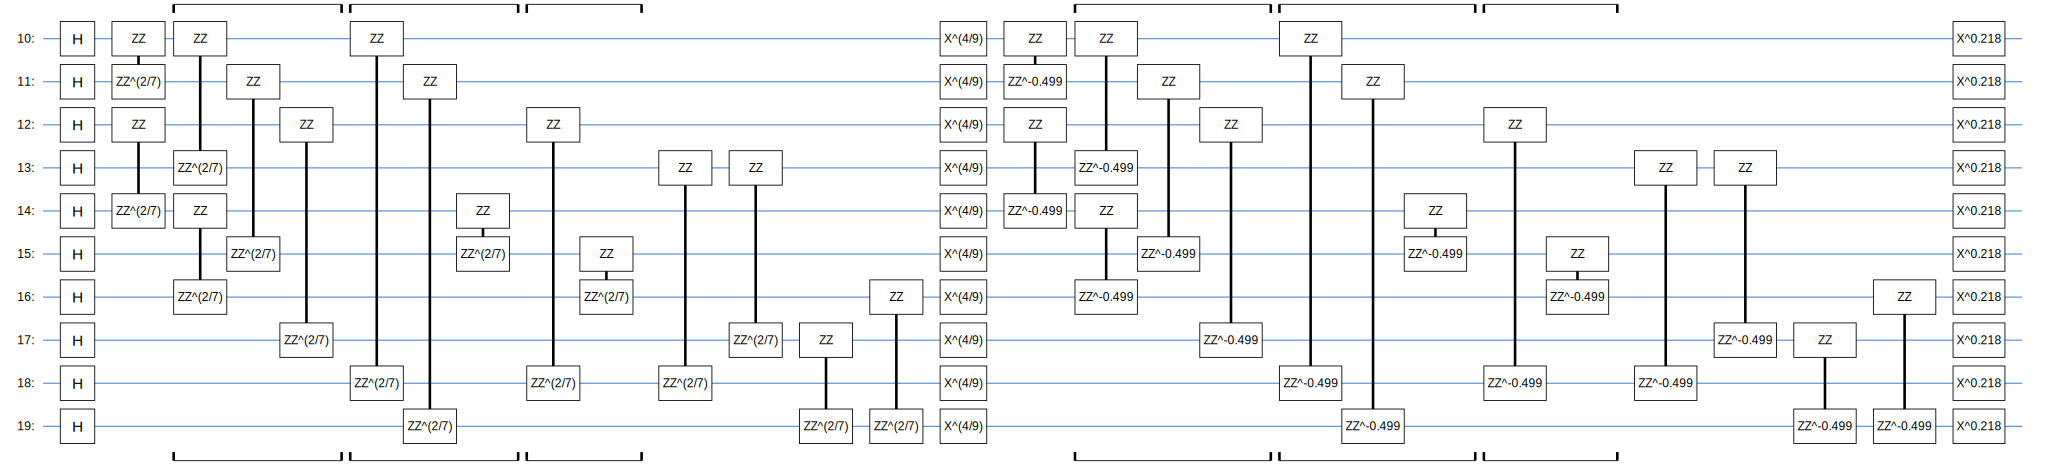

In [4]:
from recirq.qaoa.problem_circuits import get_generic_qaoa_circuit
from recirq.qaoa.gates_and_compilation import compile_problem_unitary_to_arbitrary_zz, \
    compile_driver_unitary_to_rx

problem_graph = nx.random_regular_graph(d=3, n=10)
nx.set_edge_attributes(problem_graph, values=1, name='weight')
circuit_qubits = cirq.LineQubit.range(10, 20)
gammas = np.random.randn(2)
betas = np.random.randn(2)
circuit = get_generic_qaoa_circuit(
    problem_graph=problem_graph,
    qubits=circuit_qubits,
    gammas=gammas,
    betas=betas)
circuit = compile_problem_unitary_to_arbitrary_zz(circuit)
circuit = compile_driver_unitary_to_rx(circuit)
SVGCircuit(circuit)

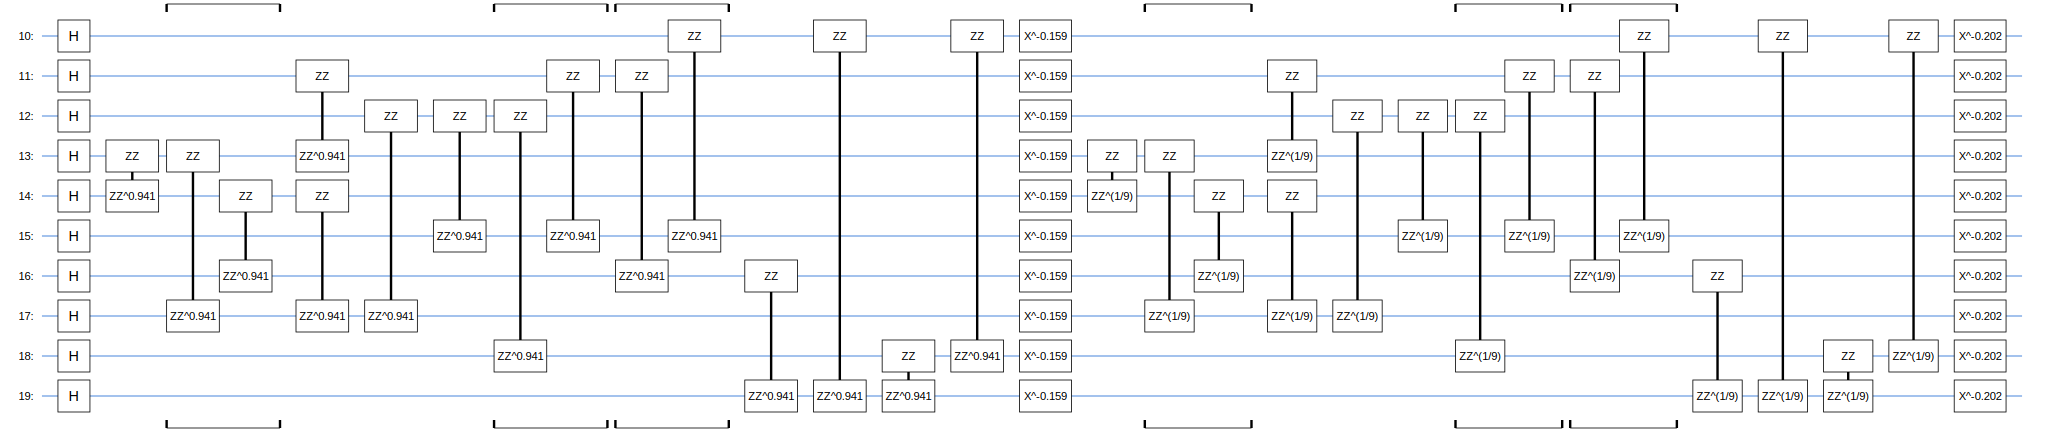

In [5]:
from recirq.qaoa.problem_circuits import get_generic_qaoa_circuit
from recirq.qaoa.gates_and_compilation import compile_problem_unitary_to_arbitrary_zz, \
    compile_driver_unitary_to_rx

problem_graph = nx.random_regular_graph(d=3, n=10)
nx.set_edge_attributes(problem_graph, values=1, name='weight')
circuit_qubits = cirq.LineQubit.range(10, 20)
gammas = np.random.randn(2)
betas = np.random.randn(2)
circuit = get_generic_qaoa_circuit(
    problem_graph=problem_graph,
    qubits=circuit_qubits,
    gammas=gammas,
    betas=betas)
circuit = compile_problem_unitary_to_arbitrary_zz(circuit)
circuit = compile_driver_unitary_to_rx(circuit)
SVGCircuit(circuit)


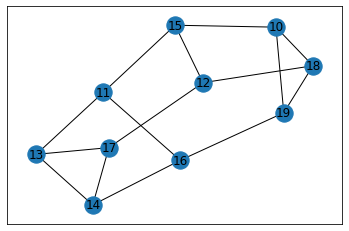

In [6]:
import cirq.contrib.routing as ccr

uncompiled_c_graph = ccr.get_circuit_connectivity(circuit)
nx.draw_networkx(uncompiled_c_graph)

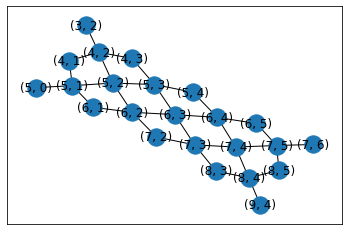

In [8]:
import cirq_google as cg

dev_graph = ccr.gridqubits_to_graph_device(cg.Sycamore23.qubits)
nx.draw_networkx(dev_graph)
device = cg.Sycamore23

In [9]:
import pytket
from pytket.circuit import Node
from recirq.qaoa.placement import _device_to_tket_device

tk_circuit = pytket.extensions.cirq.cirq_to_tk(circuit)
tk_device = _device_to_tket_device(device)

In [11]:
tk_circuit.qubits


[q[10], q[11], q[12], q[13], q[14], q[15], q[16], q[17], q[18], q[19]]

In [12]:
tk_device.coupling

[(grid[6, 4], grid[6, 5]),
 (grid[6, 4], grid[5, 4]),
 (grid[6, 4], grid[6, 3]),
 (grid[6, 4], grid[7, 4]),
 (grid[6, 5], grid[7, 5]),
 (grid[5, 4], grid[5, 3]),
 (grid[6, 3], grid[5, 3]),
 (grid[6, 3], grid[6, 2]),
 (grid[6, 3], grid[7, 3]),
 (grid[7, 4], grid[8, 4]),
 (grid[7, 4], grid[7, 3]),
 (grid[7, 4], grid[7, 5]),
 (grid[5, 2], grid[5, 3]),
 (grid[5, 2], grid[4, 2]),
 (grid[5, 2], grid[6, 2]),
 (grid[5, 2], grid[5, 1]),
 (grid[5, 3], grid[4, 3]),
 (grid[4, 2], grid[3, 2]),
 (grid[4, 2], grid[4, 3]),
 (grid[4, 2], grid[4, 1]),
 (grid[6, 2], grid[7, 2]),
 (grid[6, 2], grid[6, 1]),
 (grid[5, 1], grid[6, 1]),
 (grid[5, 1], grid[5, 0]),
 (grid[5, 1], grid[4, 1]),
 (grid[7, 2], grid[7, 3]),
 (grid[7, 3], grid[8, 3]),
 (grid[7, 5], grid[8, 5]),
 (grid[7, 5], grid[7, 6]),
 (grid[8, 4], grid[8, 5]),
 (grid[8, 4], grid[8, 3]),
 (grid[8, 4], grid[9, 4])]

In [14]:
from pytket.predicates import CompilationUnit, ConnectivityPredicate
from pytket.passes import SequencePass, RoutingPass, DecomposeSwapsToCXs, PlacementPass
from pytket.routing import GraphPlacement

In [15]:
unit = CompilationUnit(tk_circuit, [ConnectivityPredicate(tk_device)])
passes = SequencePass([
    PlacementPass(GraphPlacement(tk_device)),
    RoutingPass(tk_device)])
passes.apply(unit)
valid = unit.check_all_predicates()
assert valid

In [17]:
unit.initial_map


{q[10]: grid[7, 2],
 q[11]: grid[5, 2],
 q[12]: grid[6, 1],
 q[13]: grid[4, 1],
 q[14]: grid[4, 2],
 q[15]: grid[6, 2],
 q[16]: grid[3, 2],
 q[17]: grid[5, 1],
 q[18]: grid[6, 3],
 q[19]: grid[4, 3]}

In [18]:
def tk_to_cirq_qubit(tk):
    ind = tk.index
    return cirq.LineQubit(ind[0]) if len(ind) == 1 else cirq.GridQubit(*ind)

initial_map = {tk_to_cirq_qubit(n1): tk_to_cirq_qubit(n2) for n1, n2 in unit.initial_map.items()}
initial_map

{cirq.LineQubit(10): cirq.GridQubit(7, 2),
 cirq.LineQubit(11): cirq.GridQubit(5, 2),
 cirq.LineQubit(12): cirq.GridQubit(6, 1),
 cirq.LineQubit(13): cirq.GridQubit(4, 1),
 cirq.LineQubit(14): cirq.GridQubit(4, 2),
 cirq.LineQubit(15): cirq.GridQubit(6, 2),
 cirq.LineQubit(16): cirq.GridQubit(3, 2),
 cirq.LineQubit(17): cirq.GridQubit(5, 1),
 cirq.LineQubit(18): cirq.GridQubit(6, 3),
 cirq.LineQubit(19): cirq.GridQubit(4, 3)}

In [19]:
unit.final_map

{q[10]: grid[7, 2],
 q[11]: grid[4, 3],
 q[12]: grid[6, 1],
 q[13]: grid[3, 2],
 q[14]: grid[4, 1],
 q[15]: grid[4, 2],
 q[16]: grid[5, 2],
 q[17]: grid[5, 1],
 q[18]: grid[6, 2],
 q[19]: grid[6, 3]}

In [20]:
final_map = {tk_to_cirq_qubit(n1): tk_to_cirq_qubit(n2)
             for n1, n2 in unit.final_map.items()}
final_map

{cirq.LineQubit(10): cirq.GridQubit(7, 2),
 cirq.LineQubit(11): cirq.GridQubit(4, 3),
 cirq.LineQubit(12): cirq.GridQubit(6, 1),
 cirq.LineQubit(13): cirq.GridQubit(3, 2),
 cirq.LineQubit(14): cirq.GridQubit(4, 1),
 cirq.LineQubit(15): cirq.GridQubit(4, 2),
 cirq.LineQubit(16): cirq.GridQubit(5, 2),
 cirq.LineQubit(17): cirq.GridQubit(5, 1),
 cirq.LineQubit(18): cirq.GridQubit(6, 2),
 cirq.LineQubit(19): cirq.GridQubit(6, 3)}

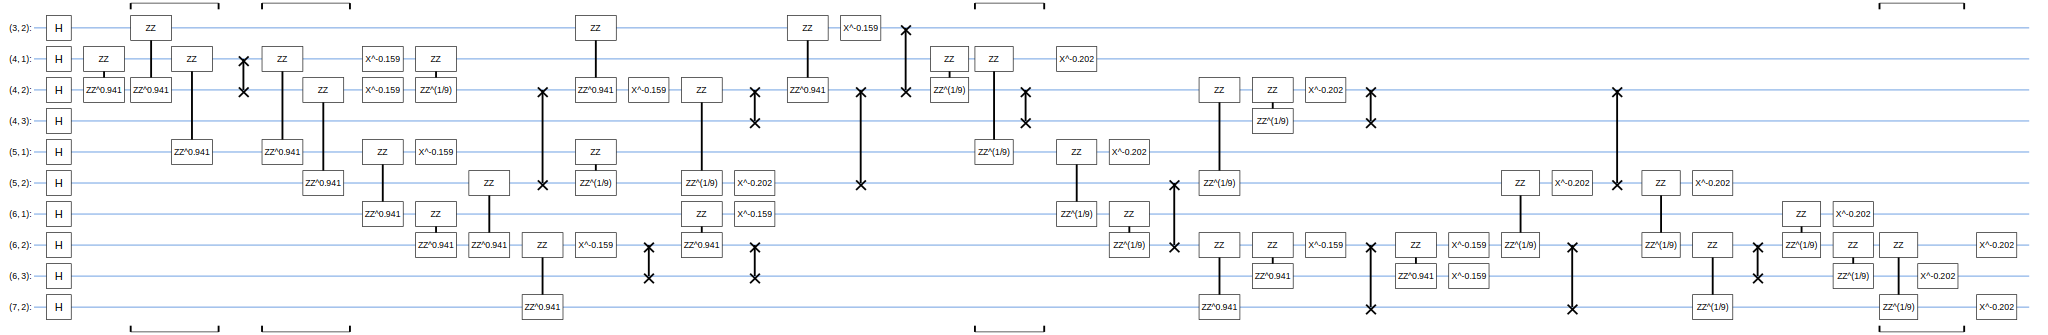

In [21]:
routed_circuit = pytket.extensions.cirq.tk_to_cirq(unit.circuit)
SVGCircuit(routed_circuit)

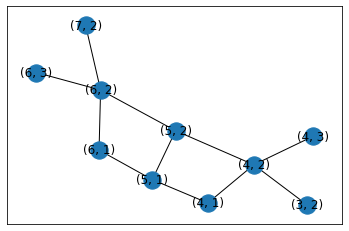

In [22]:
routed_c_graph = ccr.get_circuit_connectivity(routed_circuit)
nx.draw_networkx(routed_c_graph)